<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/Transporte_de_especies_com_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.autograd as autograd         #AD, diferenciação automática
from torch import Tensor
import torch.nn as nn                     #rede neural
import torch.optim as optim               #otimizadores
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
import numpy as np
import time
import scipy.io

In [57]:
#Padronizando o tipo dos valores
torch.set_default_dtype(torch.float)
torch.manual_seed(1234) #Uma semente para os valores, evitando a geração aleatória
np.random.seed(1234)

#Esse aqui não sei bem, mas sempre usam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

cpu


In [58]:
class RNA(nn.Module):
    def __init__(self,camadas):
        super().__init__()

        #Função de ativação
        self.ativacao = nn.Tanh()

        #Criando a rede neural
        self.linears = nn.ModuleList([nn.Linear(camadas[i], camadas[i+1]) for i in range(len(camadas)-1)])

        #inicialização normal
        for i in range(len(camadas)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)


    #propagação direta
    def forward(self,x):

        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)

        #Normalizando os dados
        x = (x - l_b)/(u_b - l_b)

        a = x.float()

        for i in range(len(camadas)-2):

            z = self.linears[i](a)
            a = self.ativacao(z)

        a = self.linears[-1](a)
        return a

In [59]:
#Classe da pinn para navier stokes
class PINN_NS():
  def __init__(self, camadas, x_r, y_r, t_r, x0, y0, t0, xc, yc, tc, u0, uc):

    self.x = torch.tensor(x_r, dtype=torch.float32, requires_grad=True).to(device)
    self.y = torch.tensor(y_r, dtype=torch.float32, requires_grad=True).to(device)
    self.t = torch.tensor(t_r, dtype=torch.float32, requires_grad=True).to(device)

    self.x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True).to(device)
    self.y0 = torch.tensor(y0, dtype=torch.float32, requires_grad=True).to(device)
    self.t0 = torch.tensor(t0, dtype=torch.float32, requires_grad=True).to(device)
    self.u0 = torch.tensor(u0, dtype=torch.float32, requires_grad=True).to(device)

    self.xc = torch.tensor(xc, dtype=torch.float32, requires_grad=True).to(device)
    self.yc = torch.tensor(yc, dtype=torch.float32, requires_grad=True).to(device)
    self.tc = torch.tensor(tc, dtype=torch.float32, requires_grad=True).to(device)
    self.uc = torch.tensor(uc, dtype=torch.float32, requires_grad=True).to(device)

    self.mse = nn.MSELoss(reduction = 'mean') #Mean Squared Error, tirado do próprio pytorch
    self.itr = 0 #Contador de iteração


    self.modelo = RNA(camadas).to(device) #Instanciando a rede neural

    self.otimizador = optim.LBFGS(self.modelo.parameters(), lr=0.01, max_iter=200000, max_eval=50000,history_size=50,
                                  tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,line_search_fn="strong_wolfe")

  def EDP(self):

    u = self.modelo(torch.hstack((self.x, self.y, self.t)))

    u_x = autograd.grad(u, self.x, torch.ones_like(u), create_graph = True)[0]
    u_xx = autograd.grad(u_x, self.x, torch.ones_like(u_x), create_graph = True)[0]

    u_y = autograd.grad(u, self.y, torch.ones_like(u), create_graph = True)[0]
    u_yy = autograd.grad(u_y, self.y, torch.ones_like(u_y), create_graph = True)[0]

    u_t = autograd.grad(u, self.t, torch.ones_like(u), create_graph = True)[0]


    f = u_t + vel*(u_y) + difus*(u_xx + u_yy)

    return u, f

  def erro(self):

    u_pred, f = self.EDP()

    #Erro dos dados
    u0_pred = self.modelo(torch.hstack((self.x0, self.y0, self.t0)))
    erro_u0 = self.mse(u0_pred, self.u0)

    uc_pred = self.modelo(torch.hstack((self.xc, self.yc, self.tc)))
    erro_uc = self.mse(uc_pred, self.uc)

    #Erro da edp
    erro_f = self.mse(f, torch.zeros_like(f))

    #Erro total
    erro_total = erro_u0 + erro_uc + erro_f

    return erro_total

  def treino_otimizador(self):

    self.otimizador.zero_grad()

    erro_total = self.erro()
    erro_total.backward()

    self.itr +=1

    if self.itr % 10 == 0:
      print('Iteração: {:}, Custo: {:0.6f}'.format(self.itr, erro_total))

    return erro_total

  def treino(self):
    self.otimizador.step(self.treino_otimizador)

  def predicao(self, x, y, t):
    pred = self.modelo(torch.hstack((x, y, t)))
    return pred

In [60]:
#Definindo os pontos X
N_0 = 200 #200 pontos para condição inicial
N_bx = 200 #200 pontos para condição de contorno em x
N_by = 200 #200 pontos para a condição de contorno em y
N_r = 20000 #Pontos para a edp

#Pontos do domínio
tmin = 0. ; tmax = 1. #Tempo de simulação
xmin = 0.; xmax = 1 #largura do duto
ymin = 0.; ymax = 10. #Diametro


#Constantes
T = 352.89 #K
v = 2.21 #m/s
vel = 2.21
#vel = torch.from_numpy(v).float().to(device)
psimeg = 2.6 #parametro do solvente
Mmeg = 1.98+2*5.48 #Peso molecular do meg, em g/mol
mi = 0.891 #Viscosidade da solução, centipoises
Va = 55.7582 #Volume molar do soluto, em cm³/g*mol
Difu = 7.4e-8 *((np.sqrt(psimeg*Mmeg)*T)/(mi*Va**0.6))
difus = 7.4e-8 *((np.sqrt(psimeg*Mmeg)*T)/(mi*Va**0.6))
#difus = torch.from_numpy(Difu).float().to(device)
lb = np.hstack((xmin, ymin, tmin)); ub = np.hstack([xmax, ymax, tmax])

In [61]:
def c_contorno(x,y,t):
  return np.where(x == 0, 1, 0)

def c_inicial(x, y):
  return np.zeros_like(x)

t0 = np.zeros((150, 1))
x0 = np.random.uniform(xmin, xmax, (150, 1))
y0 = np.random.uniform(ymin, ymax, (150, 1))
c0 = c_inicial(x0, y0)

tbx1 = np.random.uniform(tmin, tmax, (150, 1))
xbx1 = np.zeros((150,1))
ybx1 = np.random.uniform(ymin, ymax, (150, 1))
cbx1 = c_contorno(xbx1, ybx1, tbx1)

tbx2 = np.random.uniform(tmin, tmax, (150, 1))
xbx2 = np.ones((150,1))
ybx2 = np.random.uniform(ymin, ymax, (150, 1))
cbx2 = c_contorno(xbx2, ybx2, tbx2)

tby1 = np.random.uniform(tmin, tmax, (150, 1))
xby1 = np.random.uniform(xmin, xmax, (150, 1))
yby1 = np.zeros((150,1))
cby1 = c_contorno(xby1, yby1, tby1)

tby2 = np.random.uniform(tmin, tmax, (150, 1))
xby2 = np.random.uniform(xmin, xmax, (150, 1))
yby2 = np.ones((150,1))*ymax
cby2 = c_contorno(xby2, yby2, tby2)

xr = np.random.uniform(xmin, xmax, (N_r, 1))
yr = np.random.uniform(ymin, ymax, (N_r, 1))
tr = np.random.uniform(tmin, tmax, (N_r, 1))

In [62]:
xc = np.vstack((xbx1 , xbx2, xby1, xby2))
yc = np.vstack((ybx1, ybx2, yby1, yby2))
tc = np.vstack((tbx1, tbx2, tby1, tby2))
uc = np.vstack((cbx1, cbx2, cby1, cby2))

In [63]:
itr=20000
lr=0.1
camadas = np.array([3,20,20,20,20,20,20,20,20,1]) #2 nós de entradas, 8 camadas ocultas contendo 20 nós por camadas e uma saída
N_u = 100 #Número total de pontos de dados para 'u'
N_f = 25000 # Número total de pontos de colocação

In [64]:
pinn_ns = PINN_NS(camadas, xr, yr, tr, x0, y0, t0, xc, yc, tc, c0, uc)

pinn_ns.treino()

Iteração: 10, Custo: 0.215959
Iteração: 20, Custo: 0.183990
Iteração: 30, Custo: 0.162852
Iteração: 40, Custo: 0.138890
Iteração: 50, Custo: 0.112018
Iteração: 60, Custo: 0.091731
Iteração: 70, Custo: 0.052573
Iteração: 80, Custo: 0.036469
Iteração: 90, Custo: 0.031540
Iteração: 100, Custo: 0.025209
Iteração: 110, Custo: 0.022974
Iteração: 120, Custo: 0.017862
Iteração: 130, Custo: 0.015351
Iteração: 140, Custo: 0.013658
Iteração: 150, Custo: 0.012042
Iteração: 160, Custo: 0.010613
Iteração: 170, Custo: 0.009874
Iteração: 180, Custo: 0.008933
Iteração: 190, Custo: 0.007759
Iteração: 200, Custo: 0.007472
Iteração: 210, Custo: 0.007216
Iteração: 220, Custo: 0.006704
Iteração: 230, Custo: 0.006622
Iteração: 240, Custo: 0.006499
Iteração: 250, Custo: 0.006012
Iteração: 260, Custo: 0.005320
Iteração: 270, Custo: 0.005171
Iteração: 280, Custo: 0.005146
Iteração: 290, Custo: 0.005110
Iteração: 300, Custo: 0.005097
Iteração: 310, Custo: 0.005049
Iteração: 320, Custo: 0.004993
Iteração: 330, Cu

KeyboardInterrupt: 

In [65]:
N = 200
xspace = torch.linspace(xmin, xmax, N + 1)
yspace = torch.linspace(ymin, ymax, N + 1)

#em t = 0.1
t_01 = 0.1
X, Y = torch.meshgrid(xspace, yspace, indexing = 'ij')
T = torch.full_like(X, t_01)
X01 = torch.vstack([T.flatten(),X.flatten(), Y.flatten()]).T
u01 = pinn_ns.modelo(X01)
u01_np = u01.detach().numpy()
u_01 = u01_np.reshape(1, N+1, N+1)

#em t = 0.5s
t_05 = 0.5
T05 = torch.full_like(X, t_05)
X05 = torch.vstack([T05.flatten(),X.flatten(), Y.flatten()]).T
u_05 = pinn_ns.modelo(X05)
u_05 = u_05.detach().numpy()
u_05 = u_05.reshape(1, N+1, N+1)

#em t=1s
t_1 = 1.0
T1 = torch.full_like(X, t_1)
X1 = torch.vstack([T1.flatten(), X.flatten(), Y.flatten()]).T
u_1 = pinn_ns.modelo(X1)
u_1 = u_1.detach().numpy()
u_1 = u_1.reshape(1, N+1, N+1)

Xaux, Yaux = torch.meshgrid(xspace, yspace)

'\n# snapshot 3\nax   = fig.add_subplot(1, 3, 2, projection = "3d")\nsurf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")\nax.set_xlim(xmin, xmax)\nax.set_ylim(ymin, ymax)\nax.view_init(25,25)\nax.set_xlabel("x", fontstyle = "italic")\nax.set_ylabel("y", fontstyle = "italic")\nax.set_zlabel(\'c(t,x,y)\', fontstyle = "italic")\nax.set_title(\'Solução para c = c(t + x + y) em t = 1\')\n'

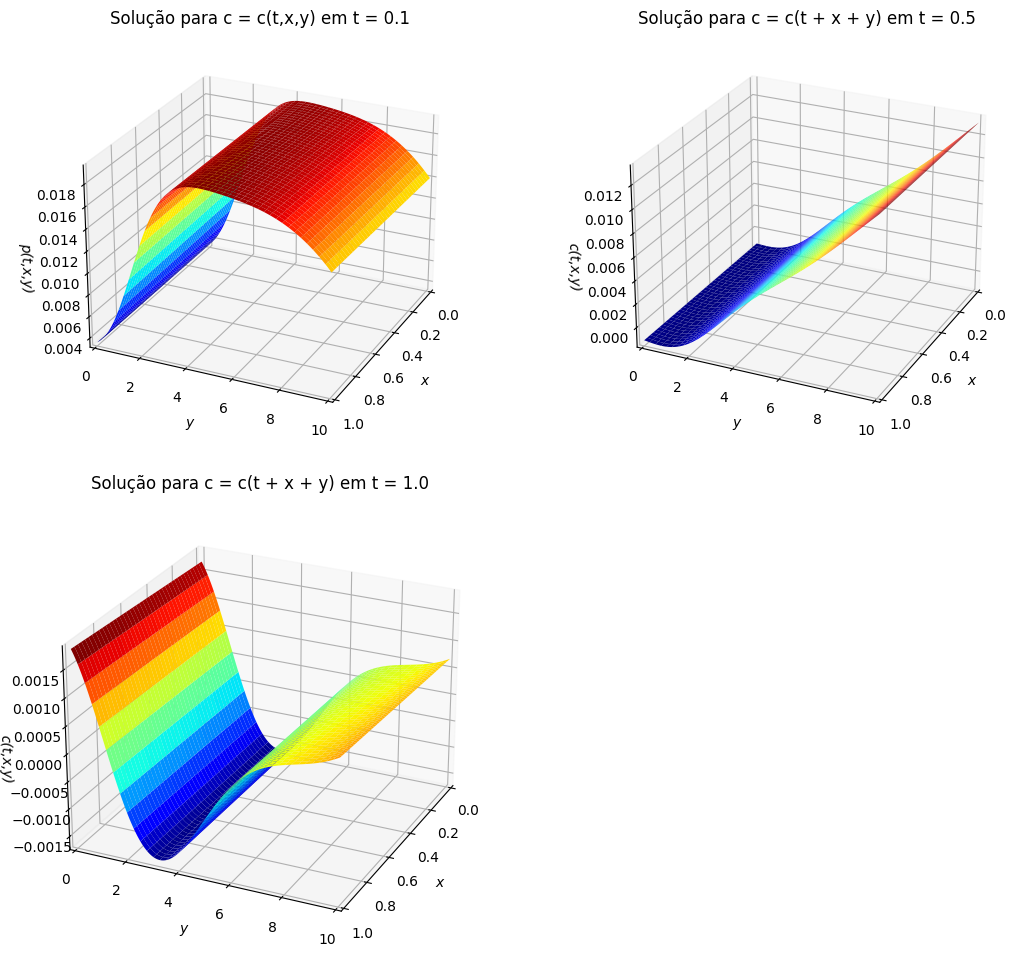

In [66]:
fig  = plt.figure(figsize = (20, 18))
# snapshot 1
ax   = fig.add_subplot(3, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, u_01[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('p(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t,x,y) em t = 0.1')

ax   = fig.add_subplot(3, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, u_05[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 0.5')
# snapshot 2
ax   = fig.add_subplot(1, 3, 1, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, u_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1.0')
'''
# snapshot 3
ax   = fig.add_subplot(1, 3, 2, projection = "3d")
surf = ax.plot_surface(Xaux, Yaux, c_1[0], cmap = "jet")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.view_init(25,25)
ax.set_xlabel("x", fontstyle = "italic")
ax.set_ylabel("y", fontstyle = "italic")
ax.set_zlabel('c(t,x,y)', fontstyle = "italic")
ax.set_title('Solução para c = c(t + x + y) em t = 1')
'''